In [167]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [168]:
from torchvision import datasets, transforms

mnist = datasets.MNIST(root='./data', download=True, transform=transforms.ToTensor())

In [169]:
mnist[0][0].shape

torch.Size([1, 28, 28])

In [170]:
def show_image(image):
    if isinstance(image, torch.Tensor):
        image = image.detach().cpu()
    plt.imshow(image.view(28, 28).numpy(), cmap='gray')
    plt.show()

In [171]:
torch.unique(mnist[0][0])

tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0353, 0.0431, 0.0549, 0.0627, 0.0706,
        0.0902, 0.0941, 0.0980, 0.1020, 0.1059, 0.1176, 0.1373, 0.1412, 0.1529,
        0.1686, 0.1765, 0.1804, 0.1922, 0.2157, 0.2196, 0.2510, 0.2588, 0.2745,
        0.3059, 0.3137, 0.3176, 0.3216, 0.3529, 0.3647, 0.3686, 0.4196, 0.4235,
        0.4471, 0.4667, 0.4941, 0.4980, 0.5098, 0.5176, 0.5216, 0.5294, 0.5333,
        0.5451, 0.5804, 0.5882, 0.6039, 0.6118, 0.6275, 0.6510, 0.6667, 0.6706,
        0.6745, 0.6863, 0.7137, 0.7176, 0.7294, 0.7333, 0.7451, 0.7647, 0.7765,
        0.7882, 0.8039, 0.8118, 0.8314, 0.8353, 0.8588, 0.8667, 0.8824, 0.8863,
        0.8980, 0.9333, 0.9412, 0.9451, 0.9490, 0.9569, 0.9686, 0.9765, 0.9804,
        0.9843, 0.9882, 0.9922, 1.0000])

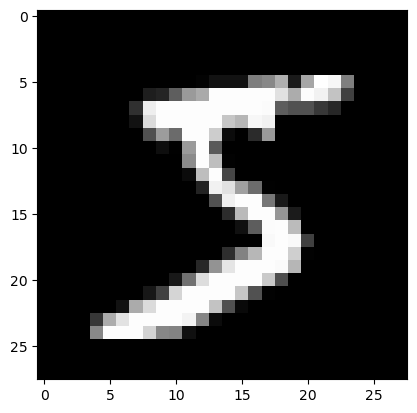

label of image is: 5


In [172]:
show_image(mnist[0][0])
print(f"label of image is: { mnist[0][1]}")

In [173]:
class Config:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    lr = 3e-4
    zDim = 128 # 64, 128, 256
    imageDim = 28 * 28 * 1  # 784
    batchSize = 32  # Batch size
    numEpochs = 20  # Change as per your need
    logStep = 625  # Change as per your need

In [174]:
class Generator(nn.Module):
    def __init__(self, zDim, imgDim, hiddenDim=512, lr=0.01):
        super().__init__()

        self.gen = nn.Sequential(
            nn.Linear(zDim, hiddenDim),
            nn.ReLU(),
            nn.Linear(hiddenDim, imgDim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.gen(x)

In [175]:
class Discriminator(nn.Module):
    def __init__(self, imgDim, hiddenDim=512):
        super().__init__()

        self.disc = nn.Sequential(
            nn.Linear(imgDim, hiddenDim),
            nn.ReLU(),
            nn.Linear(hiddenDim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [176]:
disc = Discriminator(Config.imageDim).to(Config.device)
gen = Generator(Config.zDim, Config.imageDim).to(Config.device)

fixedNoise = torch.randn((Config.batchSize, Config.zDim)).to(Config.device)

criterion = nn.BCELoss()

genOpt = torch.optim.Adam(gen.parameters(), lr=Config.lr)
discOpt = torch.optim.Adam(disc.parameters(), lr=Config.lr)

train_loader = torch.utils.data.DataLoader(mnist, batch_size=Config.batchSize, shuffle=True)

In [177]:
def train_discriminator(real, disc, gen, discOpt, criterion):
    discOpt.zero_grad()


    real = real.view(-1, Config.imageDim).to(Config.device) # Reshape images to (batchSize, imageDim)
    realLabels = torch.ones(Config.batchSize, 1).to(Config.device) # Real labels = 1
    real_outputs = disc(real) # Forward pass
    real_loss = criterion(real_outputs, realLabels) # Calculate loss

    noise = torch.randn(Config.batchSize, Config.zDim).to(Config.device) # Generate random noise
    fake = gen(noise) # Generate fake images
    fakeLabels = torch.zeros(Config.batchSize, 1).to(Config.device) # Fake labels = 0
    fake_outputs = disc(fake) # Forward pass

    fake_loss = criterion(fake_outputs, fakeLabels) # Calculate loss

    loss = real_loss + fake_loss # Total loss
    loss.backward() # Backward pass
    discOpt.step() # Update weights


    # return loss just for logging purposes
    return loss

In [178]:
def train_generator(disc, gen, genOpt, criterion):
    genOpt.zero_grad()

    noise = torch.randn(Config.batchSize, Config.zDim).to(Config.device) # Generate random noise
    fake = gen(noise) # Generate fake images

    labels = torch.ones(Config.batchSize, 1).to(Config.device) # Fake labels = 1
    outputs = disc(fake) # Forward pass

    loss = criterion(outputs, labels) # Calculate loss
    loss.backward() # Backward pass

    genOpt.step() # Update weights


    # return loss just for logging purposes
    return loss

In [179]:
import torchvision

def prepare_visualization(gen, fixedNoise):
    
    with torch.no_grad():
        # Generate noise and pass it to the generator

        fake = gen(fixedNoise).view(-1, 1, 28, 28)

        # Make a grid of images and display

        fake = torchvision.utils.make_grid(fake, nrow=8, padding=2, normalize=True, pad_value=1)

        fake = fake.permute(1, 2, 0).cpu().numpy()

        plt.imshow(fake)

        plt.show()


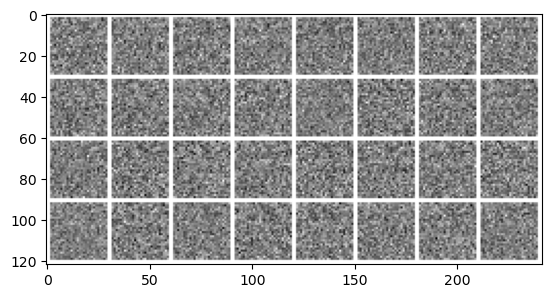

Epoch [0/20] Batch 0/1875                   Loss D: 1.4309, loss G: 0.8907


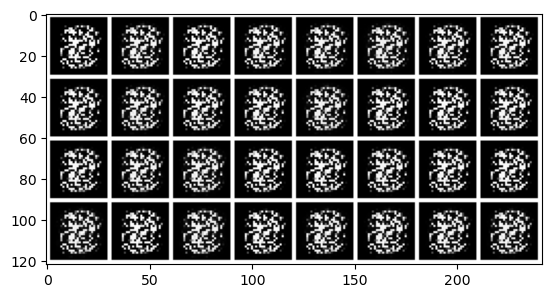

Epoch [0/20] Batch 625/1875                   Loss D: 0.0373, loss G: 4.3979


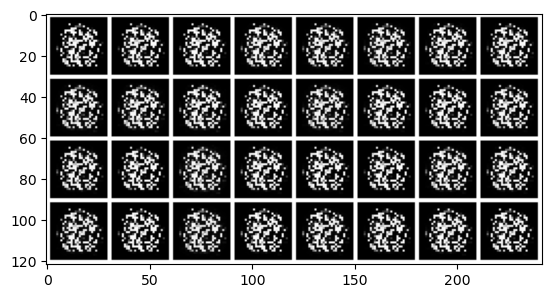

Epoch [0/20] Batch 1250/1875                   Loss D: 0.0242, loss G: 6.3681


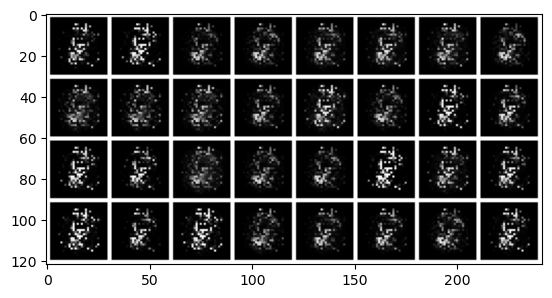

Epoch [1/20] Batch 0/1875                   Loss D: 0.0852, loss G: 4.7963


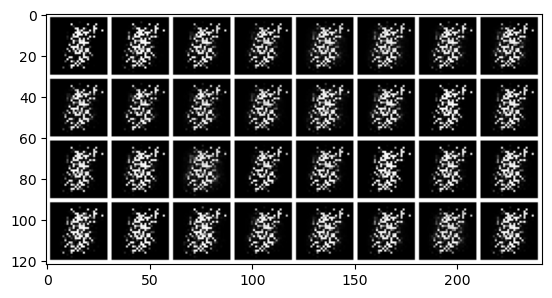

Epoch [1/20] Batch 625/1875                   Loss D: 0.0112, loss G: 5.7885


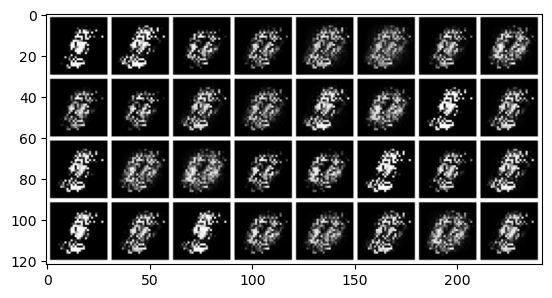

Epoch [1/20] Batch 1250/1875                   Loss D: 0.0584, loss G: 3.9916


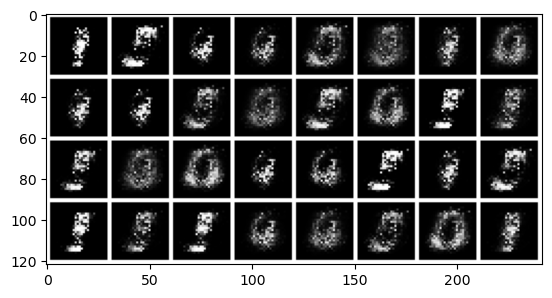

Epoch [2/20] Batch 0/1875                   Loss D: 0.0701, loss G: 3.4305


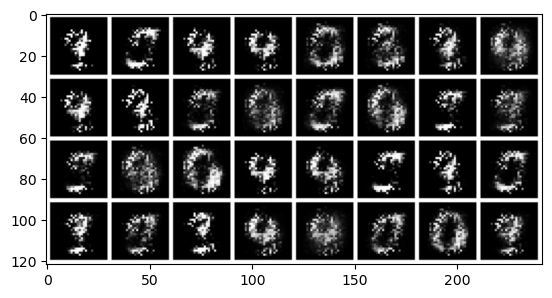

Epoch [2/20] Batch 625/1875                   Loss D: 0.0524, loss G: 4.3815


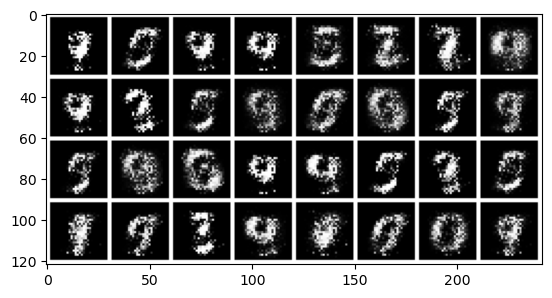

Epoch [2/20] Batch 1250/1875                   Loss D: 0.0798, loss G: 4.6333


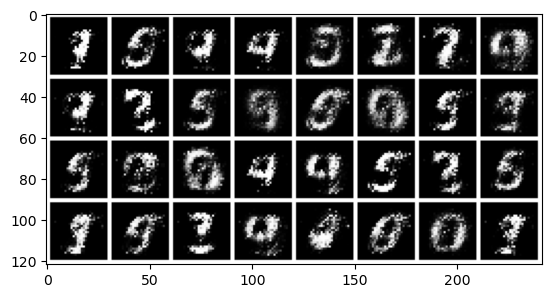

Epoch [3/20] Batch 0/1875                   Loss D: 0.2922, loss G: 4.2251


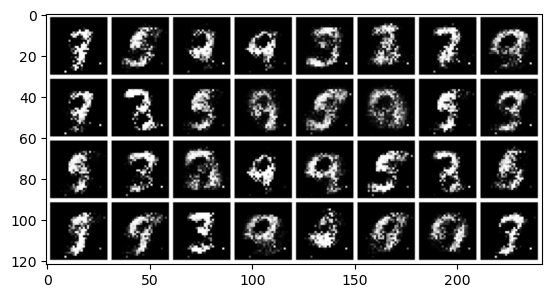

Epoch [3/20] Batch 625/1875                   Loss D: 0.1356, loss G: 4.0003


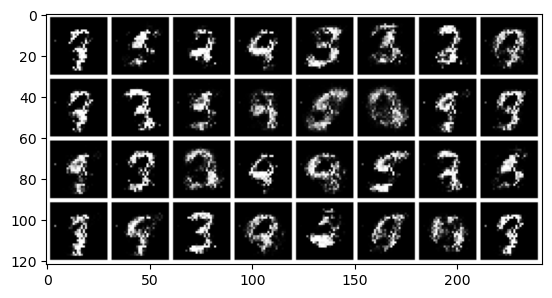

Epoch [3/20] Batch 1250/1875                   Loss D: 0.2594, loss G: 3.7874


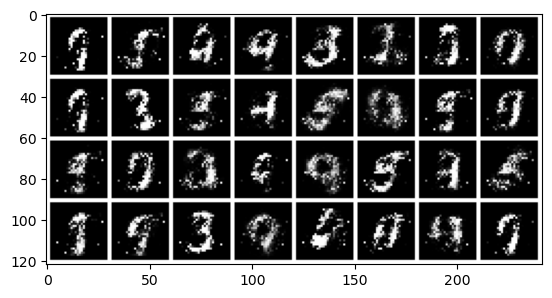

Epoch [4/20] Batch 0/1875                   Loss D: 0.1861, loss G: 4.3176


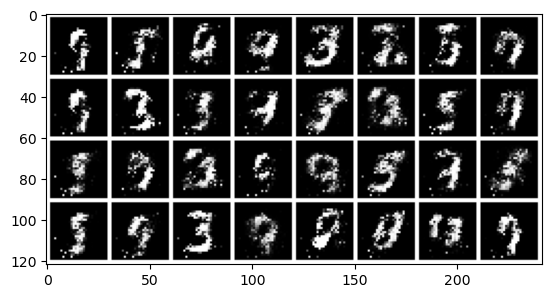

Epoch [4/20] Batch 625/1875                   Loss D: 0.1118, loss G: 4.0276


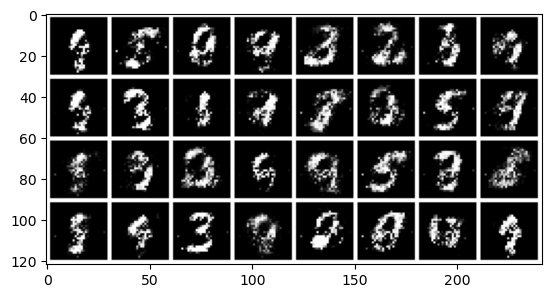

Epoch [4/20] Batch 1250/1875                   Loss D: 0.1724, loss G: 3.8132


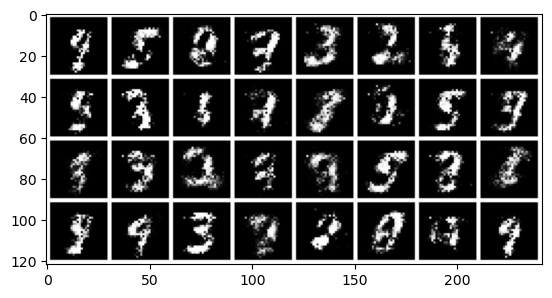

Epoch [5/20] Batch 0/1875                   Loss D: 0.2171, loss G: 3.4863


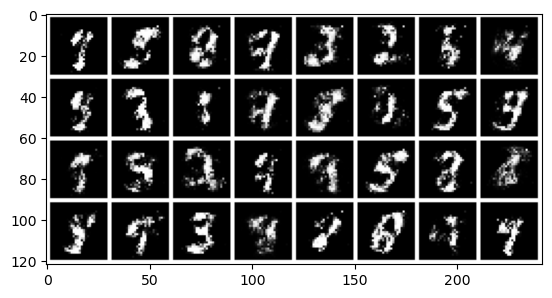

Epoch [5/20] Batch 625/1875                   Loss D: 0.1870, loss G: 3.6527


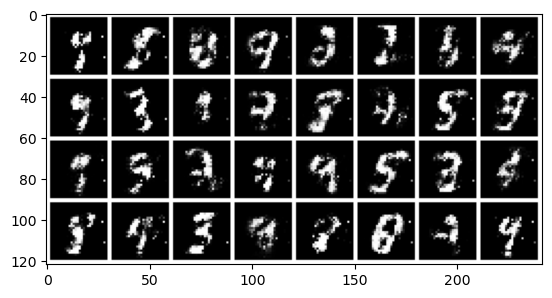

Epoch [5/20] Batch 1250/1875                   Loss D: 0.2839, loss G: 3.4562


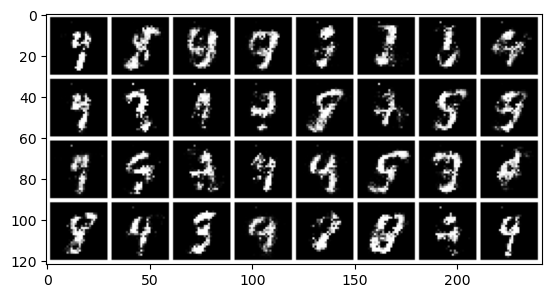

Epoch [6/20] Batch 0/1875                   Loss D: 0.4747, loss G: 2.3821


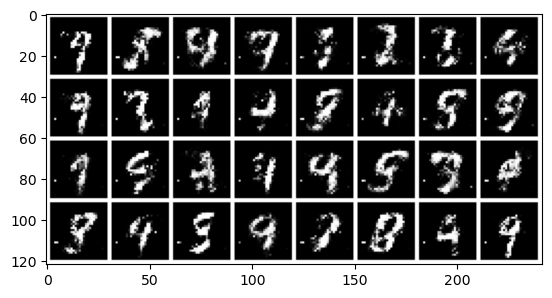

Epoch [6/20] Batch 625/1875                   Loss D: 0.2872, loss G: 3.8079


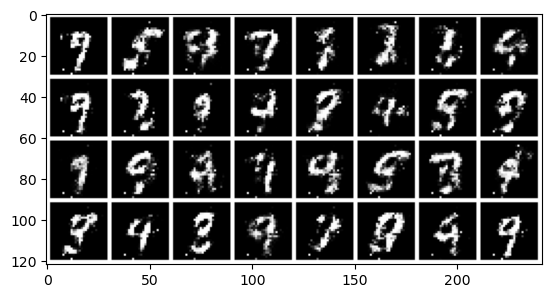

Epoch [6/20] Batch 1250/1875                   Loss D: 0.1922, loss G: 4.2892


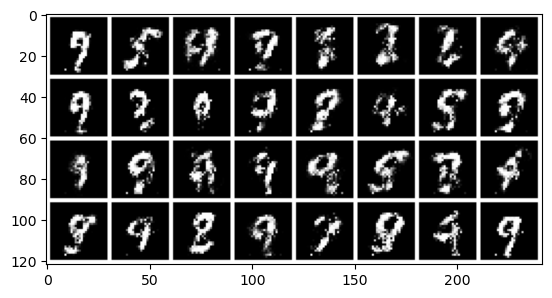

Epoch [7/20] Batch 0/1875                   Loss D: 0.3837, loss G: 2.8905


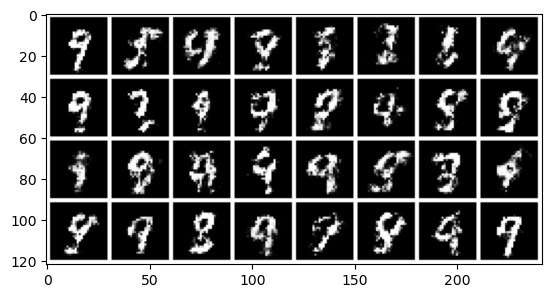

Epoch [7/20] Batch 625/1875                   Loss D: 0.2423, loss G: 2.7737


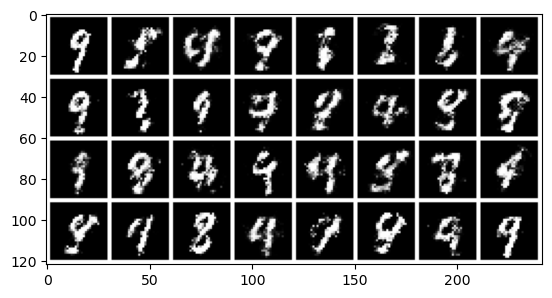

Epoch [7/20] Batch 1250/1875                   Loss D: 0.3324, loss G: 2.3161


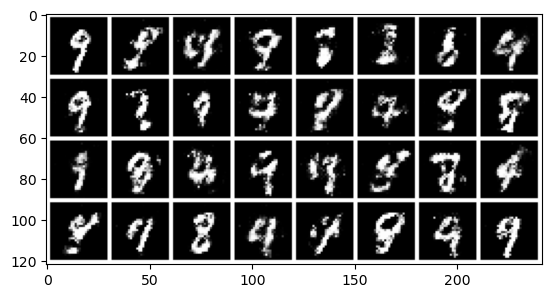

Epoch [8/20] Batch 0/1875                   Loss D: 0.5954, loss G: 2.1464


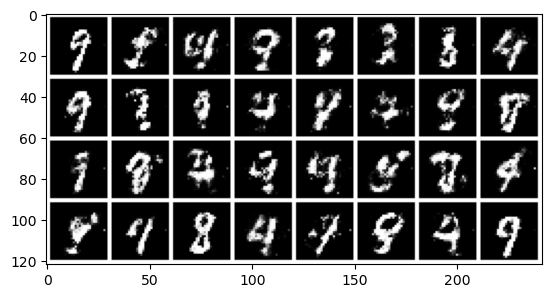

Epoch [8/20] Batch 625/1875                   Loss D: 0.3589, loss G: 2.7397


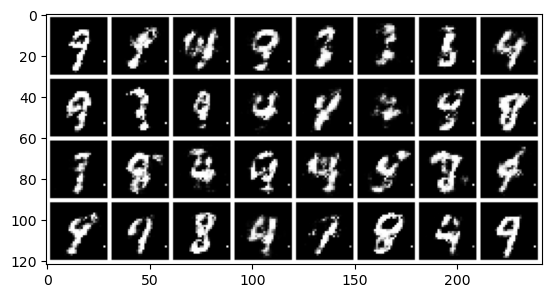

Epoch [8/20] Batch 1250/1875                   Loss D: 0.5838, loss G: 2.3446


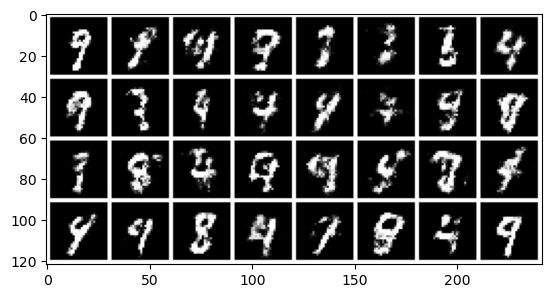

Epoch [9/20] Batch 0/1875                   Loss D: 0.5788, loss G: 1.9095


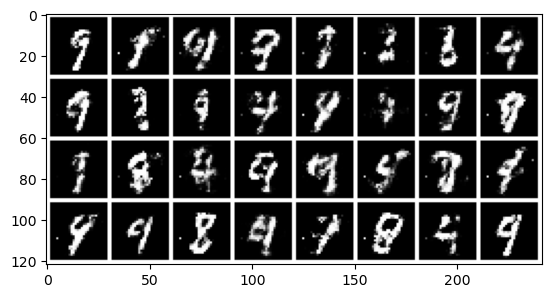

Epoch [9/20] Batch 625/1875                   Loss D: 0.4078, loss G: 2.7320


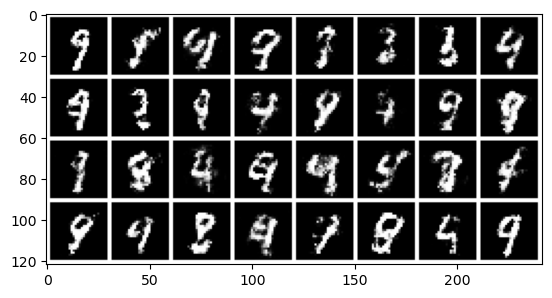

Epoch [9/20] Batch 1250/1875                   Loss D: 0.4921, loss G: 2.4737


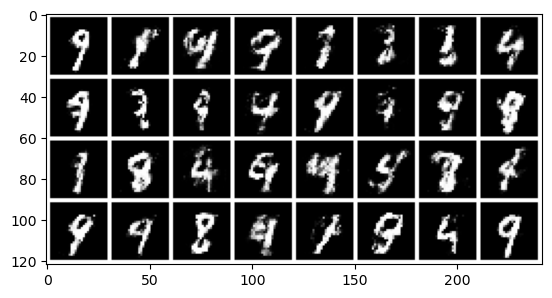

Epoch [10/20] Batch 0/1875                   Loss D: 0.5280, loss G: 2.7939


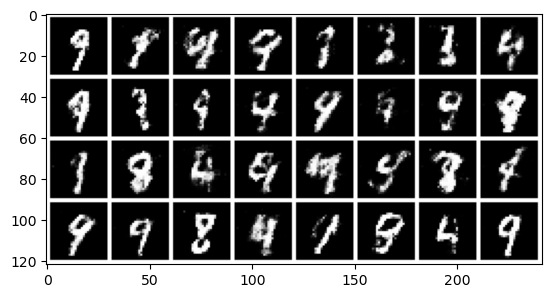

Epoch [10/20] Batch 625/1875                   Loss D: 0.4576, loss G: 2.5765


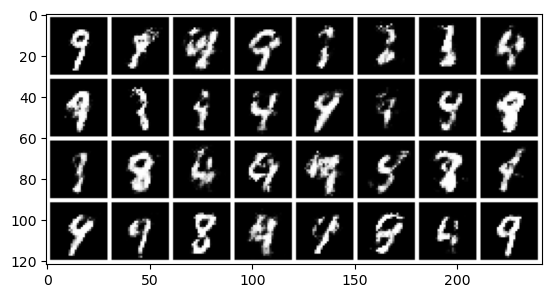

Epoch [10/20] Batch 1250/1875                   Loss D: 0.5026, loss G: 3.5225


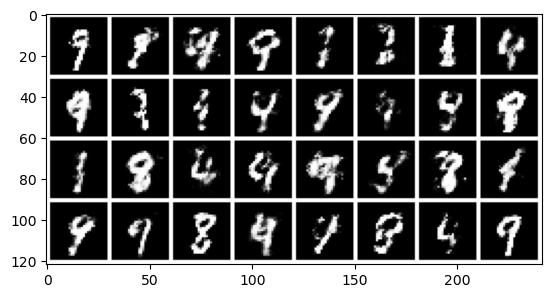

Epoch [11/20] Batch 0/1875                   Loss D: 0.4609, loss G: 2.6443


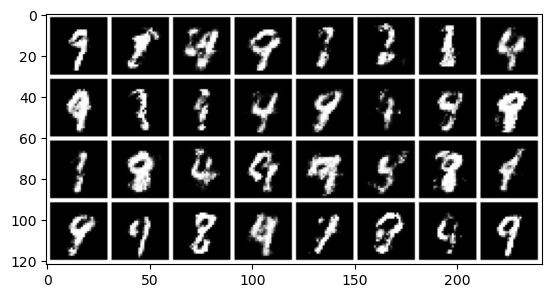

Epoch [11/20] Batch 625/1875                   Loss D: 0.5781, loss G: 2.6148


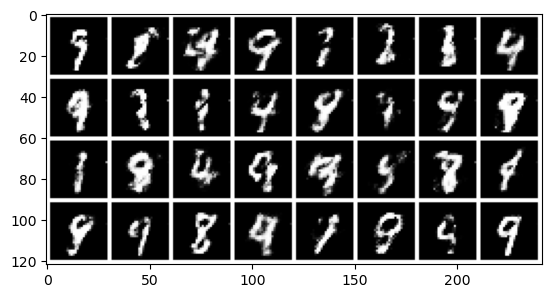

Epoch [11/20] Batch 1250/1875                   Loss D: 0.4855, loss G: 2.0976


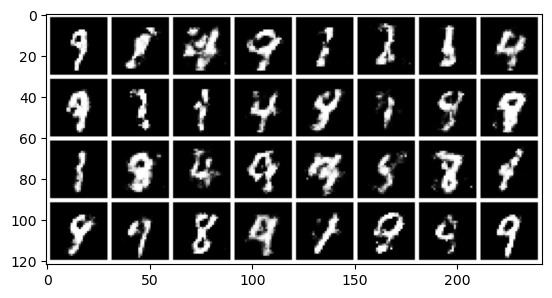

Epoch [12/20] Batch 0/1875                   Loss D: 0.6915, loss G: 2.6333


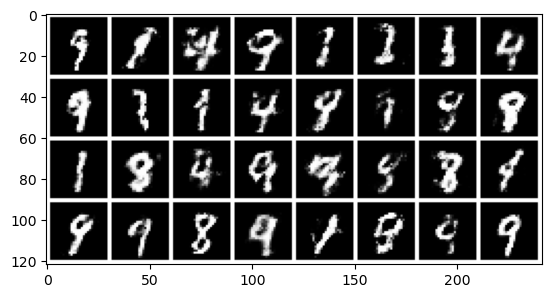

Epoch [12/20] Batch 625/1875                   Loss D: 0.4685, loss G: 2.7662


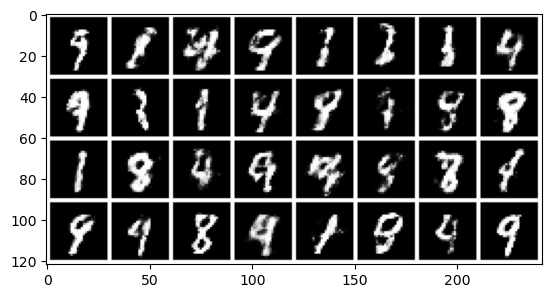

Epoch [12/20] Batch 1250/1875                   Loss D: 0.3759, loss G: 2.0487


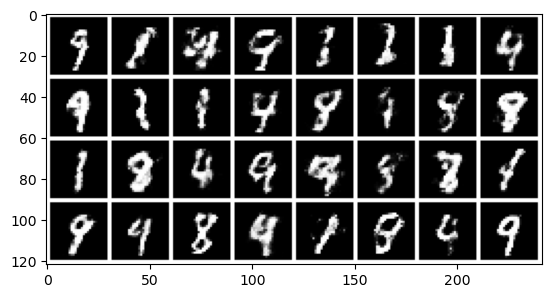

Epoch [13/20] Batch 0/1875                   Loss D: 0.6808, loss G: 2.7874


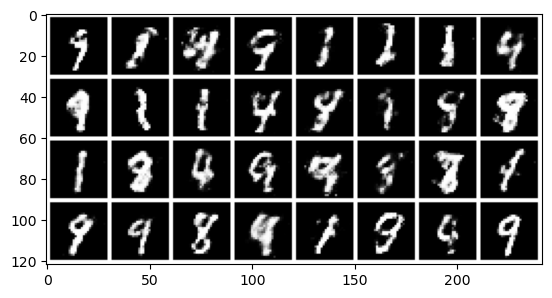

Epoch [13/20] Batch 625/1875                   Loss D: 0.6218, loss G: 3.3742


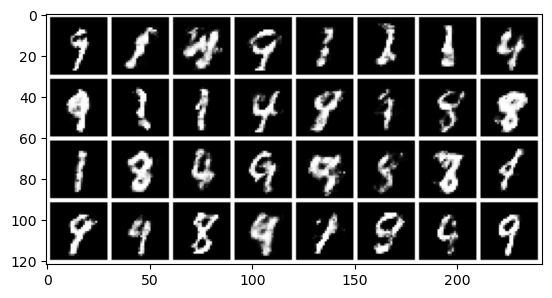

Epoch [13/20] Batch 1250/1875                   Loss D: 0.6079, loss G: 2.7332


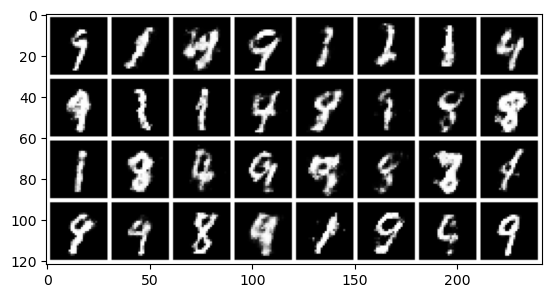

Epoch [14/20] Batch 0/1875                   Loss D: 0.5241, loss G: 2.3726


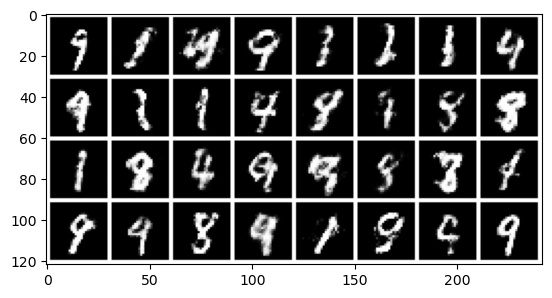

Epoch [14/20] Batch 625/1875                   Loss D: 0.5950, loss G: 2.5109


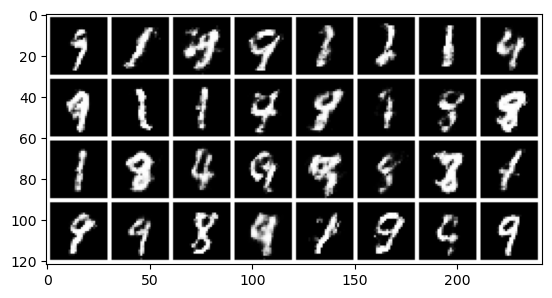

Epoch [14/20] Batch 1250/1875                   Loss D: 0.5649, loss G: 2.8340


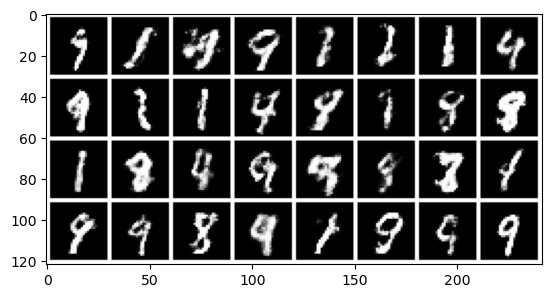

Epoch [15/20] Batch 0/1875                   Loss D: 0.3538, loss G: 2.5306


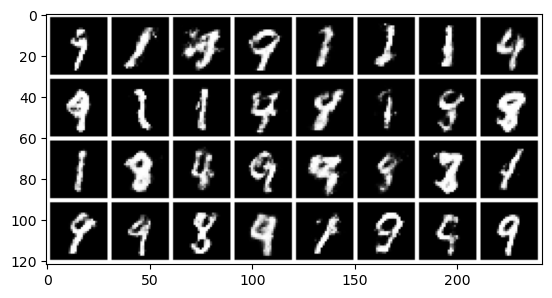

Epoch [15/20] Batch 625/1875                   Loss D: 0.4642, loss G: 2.0764


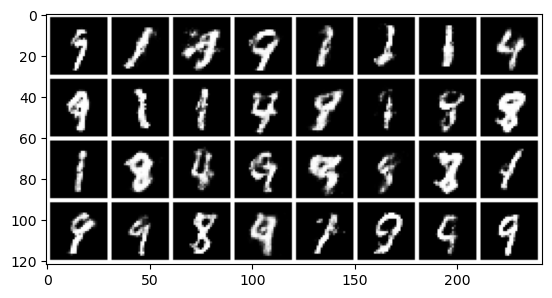

Epoch [15/20] Batch 1250/1875                   Loss D: 0.5054, loss G: 2.3590


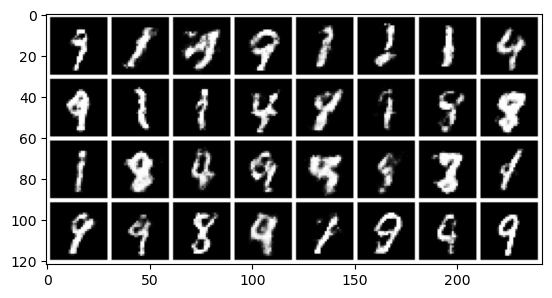

Epoch [16/20] Batch 0/1875                   Loss D: 0.4133, loss G: 2.3459


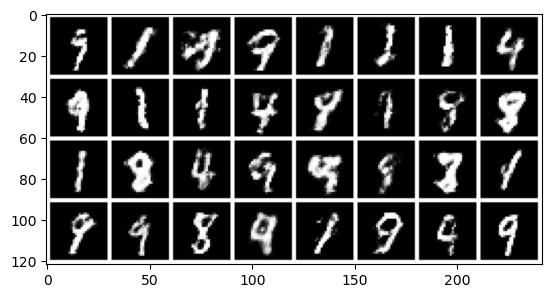

Epoch [16/20] Batch 625/1875                   Loss D: 0.3923, loss G: 2.8188


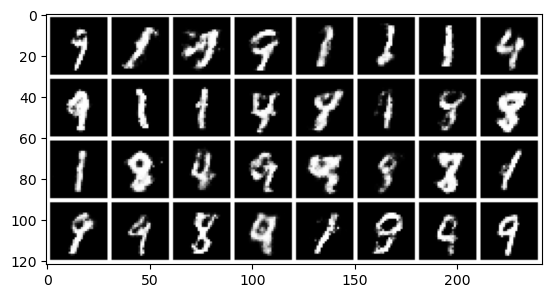

Epoch [16/20] Batch 1250/1875                   Loss D: 0.5700, loss G: 2.1821


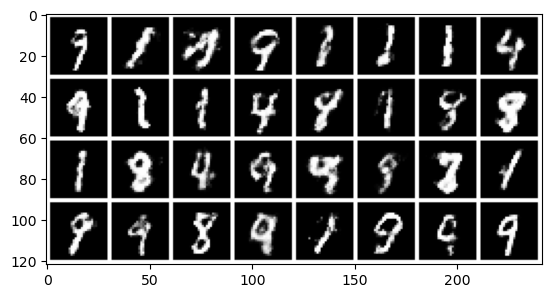

Epoch [17/20] Batch 0/1875                   Loss D: 0.5675, loss G: 2.4222


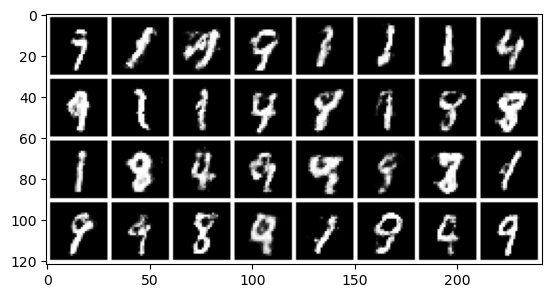

Epoch [17/20] Batch 625/1875                   Loss D: 0.3028, loss G: 2.5642


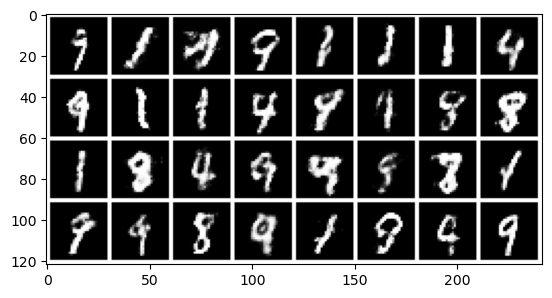

Epoch [17/20] Batch 1250/1875                   Loss D: 0.3636, loss G: 2.7687


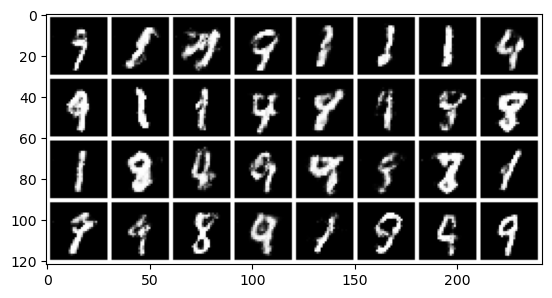

Epoch [18/20] Batch 0/1875                   Loss D: 0.4140, loss G: 2.1328


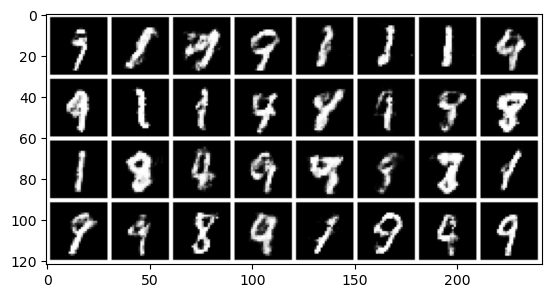

Epoch [18/20] Batch 625/1875                   Loss D: 0.5988, loss G: 2.6664


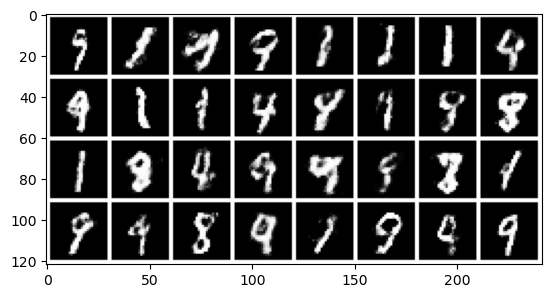

Epoch [18/20] Batch 1250/1875                   Loss D: 0.4586, loss G: 2.7558


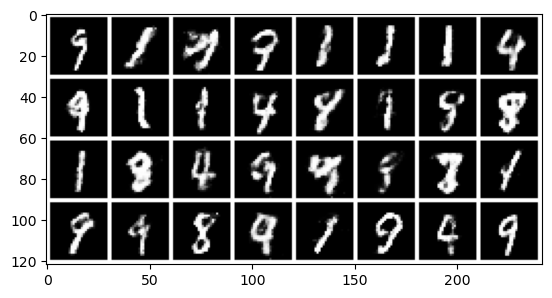

Epoch [19/20] Batch 0/1875                   Loss D: 0.5707, loss G: 2.2315


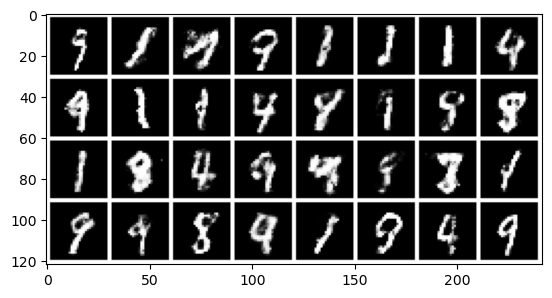

Epoch [19/20] Batch 625/1875                   Loss D: 0.4990, loss G: 2.1309


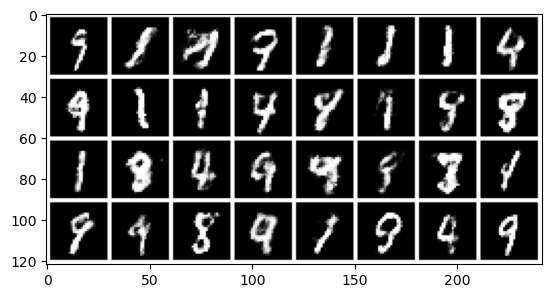

Epoch [19/20] Batch 1250/1875                   Loss D: 0.6884, loss G: 2.5075


In [180]:
for epoch in range(Config.numEpochs):
    
    for batch_idx, (real, _) in enumerate(train_loader):
        
        # Train Discriminator and get the loss just for logging
        lossD = train_discriminator(real, disc, gen, discOpt, criterion)

        # Train Generator and get the loss just for logging
        lossG = train_generator(disc, gen, genOpt, criterion)

        if batch_idx % Config.logStep == 0:
            prepare_visualization(gen, fixedNoise)

            print(f"Epoch [{epoch}/{Config.numEpochs}] Batch {batch_idx}/{len(train_loader)} \
                  Loss D: {lossD:.4f}, loss G: {lossG:.4f}")